# Libraries

In [6]:
import tensorflow as tf
import math
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import  AveragePooling2D, UpSampling2D, BatchNormalization, Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Reshape, Conv2DTranspose, Embedding, Concatenate, Multiply, Add, Lambda
from tensorflow.keras.layers.experimental.preprocessing import Normalization 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Data Loader, Writers

In [2]:
#Display some test images from the test set of tiny-imagenet
def display_formatted_image(data_loc, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    data = np.load(data_loc)
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    random_images = data[np.random.choice(data.shape[0], num_col*num_row)]
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = img_to_array(random_images[i])
        img = img.astype(int)
        
        d_size = img.shape
        ax.imshow(img)
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    print("Image dimension in the dataset: ",d_size)

Bit-emoji Dataset Samples: 


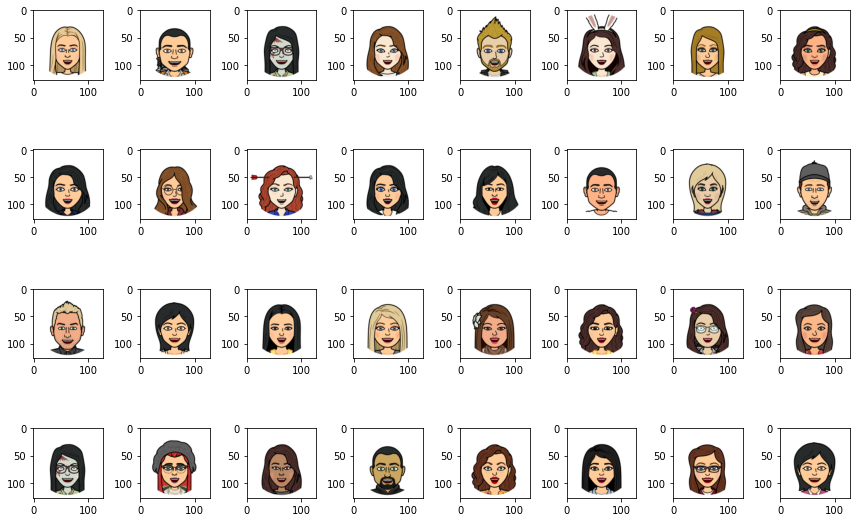

Image dimension in the dataset:  (128, 128, 3)


In [3]:
print("Bit-emoji Dataset Samples: ")
display_formatted_image("../../Assignment1/Code/Data/bit-emojis/emojis.npy", 4, 8)

In [4]:
def save_raw_data(dataloc, saveloc):
    folders = os.listdir(dataloc)
    X = []
    img_names = os.listdir(dataloc)
    for img in img_names:
        img = img_to_array(load_img(dataloc+img)).astype('uint8')
        X.append(img)
            
    X = np.array(X)
    
    with open(saveloc, 'wb') as fptr:
        np.save(fptr, X)
        
    print(X.shape)
#save_raw_data("./CelebA/img_align_celeba/", "./CelebA/celeba.npy")

CelebA dataset: 


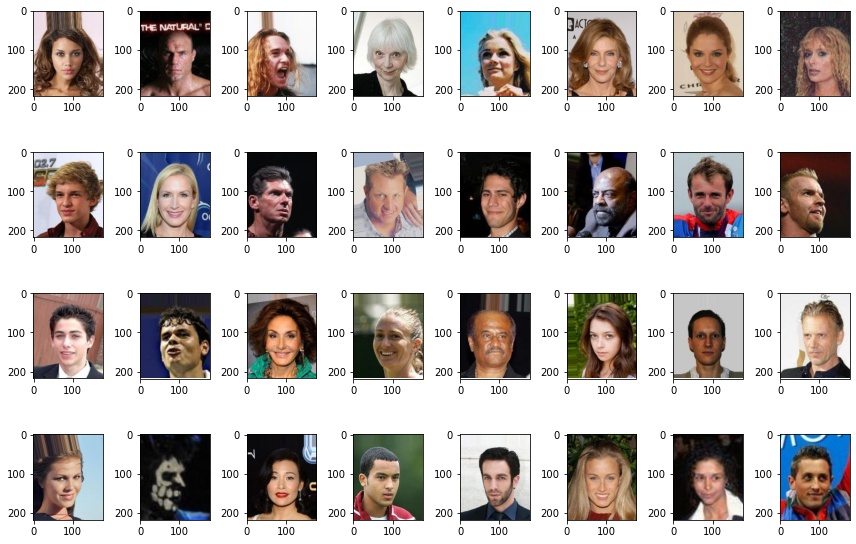

Image dimension in the dataset:  (218, 178, 3)


In [5]:
print("CelebA dataset: ")
display_formatted_image("./CelebA/celeba.npy", 4, 8)

# Architectures and Algorithms

$1. \bf My \space Unet$

In [7]:
# optimization
class UNET(object):
    
    def __init__(self, n_layers, n_filters, inp_shape):
        #the paper suggests f_max to be log(T) 
        
        self.arch_hyperparameters = {'l2_conv': 0.0001
                                }
        self.inp_shape = inp_shape
        #using https://arxiv.org/abs/2010.02502
        #exact embeddings used
        
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.unet_model = None
    
    #before you begin idea is to add an embedding channel to make the data (None, m, n, 4), to propagate this information,
    #a linear 1x1 convolution is done in the image, followed by a (None, m, n, 3)
    def get_sinusoidal_embedding_channel(self, t_var):
        #fix the omegas and the number of channels to add
        omegas = 2.0*math.pi*tf.exp(tf.linspace(0.0, math.log(1000), 8))
        
        sinusoid_emb = Lambda(lambda x: tf.concat([tf.sin(x[0] * x[1]), tf.cos(x[0] * x[1])], axis=3), name='Embedding_layer')([omegas, t_var])
        return sinusoid_emb

   
    def conv_block_ds(self, inp, layer, n_filters):
        #using standard u-net architecture
        conv_op = Conv2D(n_filters, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'ds_conv_'+str(layer)+'_a')(inp)
        conv_op = BatchNormalization(name='ds_batch_norm_l'+str(layer)+"_a")(conv_op)
        conv_op = Conv2D(n_filters, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'ds_conv_'+str(layer)+'_b')(conv_op)
        conv_op = BatchNormalization(name='ds_batch_norm_l'+str(layer)+"_b")(conv_op)
        #maxpool:
        mpool = MaxPool2D((2,2), strides=(2,2), padding='same', name='ds_maxpool_'+str(layer))(conv_op)
        
        return conv_op, mpool

    def conv_block_us(self, inp, inp_skip, layer, n_filter1, n_filter2):
        #upsample:
        inp = Conv2DTranspose(inp.shape[-1], (3,3), strides=(2,2), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'convTrans_'+str(layer))(inp)
        inp = BatchNormalization(name='us_batch_norm_l'+str(layer)+'_a')(inp)
        #inp resize
        inp = Lambda(lambda x: tf.image.resize_with_crop_or_pad(x[0], x[1].shape[1], x[1].shape[2]), name='us_resize_'+str(layer))([inp, inp_skip])
        u_conv_out = Concatenate(name='concat_'+str(layer))([inp, inp_skip])
        u_conv_op = Conv2D(n_filter1, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'us_conv_'+str(layer)+'_a')(u_conv_out)
        u_conv_op = BatchNormalization(name='us_batch_norm_l'+str(layer)+'_b')(u_conv_op)
        u_conv_op = Conv2D(n_filter2, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'us_conv_'+str(layer)+'_b')(u_conv_op)
        u_conv_op = BatchNormalization(name='us_batch_norm_l'+str(layer)+'_c')(u_conv_op)
        return u_conv_op

    def make_UNET(self):
        inp = Input(shape=self.inp_shape, name='unet_input')
        t = Input(shape=(1,1,1), name='t_vars_proxy')
        #get time embedding
        t_emb = self.get_sinusoidal_embedding_channel(t)
        #make another channel of it
        t_emb = UpSampling2D(size=self.inp_shape[0], interpolation="nearest")(t_emb)
        for_dat = Concatenate(name="input_time_added")([inp, t_emb])

        for_dat = Conv2D(self.n_filters[0], (1,1), strides=(1,1), activation=None, padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'inp_mix_time_info')(for_dat)
        
        conv_ds = []
        #starting the forward pass

        for i in range(self.n_layers-1):
            conv_op, for_dat = self.conv_block_ds(for_dat, i, self.n_filters[i+1])
            conv_ds.append(conv_op)

        for_dat = Conv2D(self.n_filters[self.n_layers-1], (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_layer_withoutskip')(for_dat)
        for_dat = BatchNormalization(name='bn_withoutskip')(for_dat)
        #this is the upsampling part
        for i in range(self.n_layers-1):
            for_dat = self.conv_block_us(for_dat, conv_ds[self.n_layers - i - 2], i, self.n_filters[self.n_layers - i - 1], self.n_filters[self.n_layers - i - 2])

        #for_dat = Concatenate(name="output_time_added")([for_dat, t_emb])
        for_dat = Conv2D(self.n_filters[0], (1,1), strides=(1,1), padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'scale_output_final')(for_dat)
        self.unet_model = Model(inputs=[inp, t], outputs=for_dat, name='Unet_model')
        
        self.unet_model.compile()
        #self.unet_model.summary()
        
    def make_UNET_yappended(self, n_attr):
        inp = Input(shape=self.inp_shape, name='unet_input')
        t = Input(shape=(1,1,1), name='t_vars_proxy')
        y = Input(shape=(n_attr, 1, 1), name='labels')
        y_upsamp = UpSampling2D(size=(int(self.inp_shape[0]/n_attr), self.inp_shape[1]), interpolation="nearest")(y)
        y_upsamp = Lambda(lambda x: tf.image.resize_with_crop_or_pad(x[0], x[1].shape[1], x[1].shape[2]), name='y_labels_resize')([y_upsamp, inp])
        #get time embedding
        t_emb = self.get_sinusoidal_embedding_channel(t)
        #make another channel of it
        t_emb = UpSampling2D(size=(self.inp_shape[0], self.inp_shape[1]), interpolation="nearest")(t_emb)
        for_dat = Concatenate(name="input_time_y_added")([inp, t_emb, y_upsamp])

        for_dat = Conv2D(self.n_filters[0], (1,1), strides=(1,1), activation=None, padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'inp_mix_time_info')(for_dat)
        
        conv_ds = []
        #starting the forward pass

        for i in range(self.n_layers-1):
            conv_op, for_dat = self.conv_block_ds(for_dat, i, self.n_filters[i+1])
            conv_ds.append(conv_op)

        for_dat = Conv2D(self.n_filters[self.n_layers-1], (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_layer_withoutskip')(for_dat)
        for_dat = BatchNormalization(name='bn_withoutskip')(for_dat)
        #this is the upsampling part
        for i in range(self.n_layers-1):
            for_dat = self.conv_block_us(for_dat, conv_ds[self.n_layers - i - 2], i, self.n_filters[self.n_layers - i - 1], self.n_filters[self.n_layers - i - 2])

        #for_dat = Concatenate(name="output_time_added")([for_dat, t_emb])
        for_dat = Conv2D(self.n_filters[0], (1,1), strides=(1,1), padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'scale_output_final')(for_dat)
        self.unet_model = Model(inputs=[inp, t, y], outputs=for_dat, name='Unet_model')
        
        self.unet_model.compile()
        #self.unet_model.summary()
        

In [10]:
example_unet = UNET(5, [3, 16, 32, 64, 128], (128, 128, 3))
example_unet.make_UNET()
example_unet.unet_model.summary()

Model: "Unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t_vars_proxy (InputLayer)      [(None, 1, 1, 1)]    0           []                               
                                                                                                  
 Embedding_layer (Lambda)       (None, 1, 1, 16)     0           ['t_vars_proxy[0][0]']           
                                                                                                  
 unet_input (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, 128, 128, 16  0          ['Embedding_layer[0][0]'

                                                                  'ds_batch_norm_l3_b[0][0]']     
                                                                                                  
 us_conv_0_a (Conv2D)           (None, 16, 16, 128)  295040      ['concat_0[0][0]']               
                                                                                                  
 us_batch_norm_l0_b (BatchNorma  (None, 16, 16, 128)  512        ['us_conv_0_a[0][0]']            
 lization)                                                                                        
                                                                                                  
 us_conv_0_b (Conv2D)           (None, 16, 16, 64)   73792       ['us_batch_norm_l0_b[0][0]']     
                                                                                                  
 us_batch_norm_l0_c (BatchNorma  (None, 16, 16, 64)  256         ['us_conv_0_b[0][0]']            
 lization)

$\bf \text  {2. The diffusion Model: Vanilla Version}$

In [11]:
class Diffusion_Model(object):
    def __init__(self, input_shape, T):
        #T is the mixing time
        self.input_shape = input_shape
        self.arch_hyperparameters = {
                                     'sub_sample_t': 10,
                                     'batch_size': 16,
                                     'lr': 0.001,
                                     'T': T,
                                     'alpha_t': np.linspace((1-1e-4), 0.97, T+1),
                                     'alpha_t_bar': [],
                                     'sigma_q_t_2': [-1, -1]
                                    }
        self.calculate_alphas()
        
        self.omega_emb = None
        self.phi_emb = None
        
        self.u_net_diff = None
        self.optimizer = None
        
    
    def make_model(self):
        #u_net_recons = UNET(4, [3, 16, 32, 64], self.input_shape, False, self.arch_hyperparameters['T'])
        #u_net_recons.make_UNET()
        #self.u_net_recons = u_net_recons.unet_model
        
        u_net_diff = UNET(5, [3, 32, 64, 96, 128], self.input_shape)
        u_net_diff.make_UNET()
        #assign the models
        self.u_net_diff = u_net_diff.unet_model
        
        self.u_net_diff.summary()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        
        self.omega_emb = u_net_diff.omega_emb
        self.phi_emb = u_net_diff.phi_emb
        
    def save_model(self, path):
        self.u_net_diff.save(path+"unet_diff")
        #self.u_net_recons.save(path+"unet_recons")
        #save the embeddings
        with open(path+"omega_emb.npy", 'wb') as fptr:
            np.save(fptr, self.omega_emb)
        with open(path+"phi_emb.npy", 'wb') as fptr:
           np.save(fptr, self.phi_emb)
        
    def load_mymodel(self, path):
        print("Loading Model")
        self.u_net_diff = load_model(path+"unet_diff")
        self.u_net_diff.compile()
        self.u_net_diff.summary()
    
        #self.u_net_recons = load_model(path+"unet_recons")
        #self.u_net_recons.compile()
        #self.u_net_recons.summary()
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        #load the embeddings
        self.omega_emb = np.load(path+"omega_emb.npy")
        self.omega_emb = tf.constant(self.omega_emb, dtype='float32', name='omega_emb_val')
        self.phi_emb = np.load(path+"phi_emb.npy")
        self.phi_emb = tf.constant(self.phi_emb, dtype='float32', name='omega_emb_val')
        
    def calculate_alphas(self):
        #using dyanamic programming approach to keep constants stored to prevent recalculation
        #a_0 = self.arch_hyperparameters['alpha_0']
        for i in range(self.arch_hyperparameters['T']+1):
            #schedule: a_t = a_0/(i+1)
            #a_t = a_0/(i+1)
            #self.arch_hyperparameters['alpha_t'].append(a_t)
            #cumulative product a_t_bar
            if i <= 1:
                self.arch_hyperparameters['alpha_t_bar'].append(self.arch_hyperparameters['alpha_t'][i])
            else:
                a_t_1_bar = self.arch_hyperparameters['alpha_t_bar'][i-1]
                self.arch_hyperparameters['alpha_t_bar'].append(a_t_1_bar*self.arch_hyperparameters['alpha_t'][i])
            
            #sigma_q_t_2 is for t>=2
            if i>=2:
                sqt2 = (1-self.arch_hyperparameters['alpha_t'][i])*(1-self.arch_hyperparameters['alpha_t_bar'][i-1])/(1-self.arch_hyperparameters['alpha_t_bar'][i])
                self.arch_hyperparameters['sigma_q_t_2'].append(sqt2)
        
        #self.arch_hyperparameters['alpha_t'] = np.array(self.arch_hyperparameters['alpha_t'])
        self.arch_hyperparameters['alpha_t_bar'] = np.array(self.arch_hyperparameters['alpha_t_bar'])
        self.arch_hyperparameters['sigma_q_t_2'] = np.array(self.arch_hyperparameters['sigma_q_t_2'])
        print(self.arch_hyperparameters['sigma_q_t_2'])
        
    def X_t(self, data_X_0, t_vector):
        #returns the noise added images
        u_xt_giv_x0 = np.expand_dims(np.sqrt(self.arch_hyperparameters['alpha_t_bar'][t_vector]), axis=[1,2,3])*data_X_0
        sigma_xt_giv_x0 = np.expand_dims(np.sqrt((1 - self.arch_hyperparameters['alpha_t_bar'][t_vector])), axis=[1,2,3])
        
        eps = np.random.normal(size=data_X_0.shape) 
        
        X_t = u_xt_giv_x0 + sigma_xt_giv_x0*eps
        return X_t, eps
    
    def loss(self, batch):
        #t1s = np.ones(batch.shape[0], dtype='int32')
        #batch_X1s = self.X_t(batch, t1s)
        
        #get all X_ts random selected for each image
        #generate a list of random numbers [2, T]*num_image*number_estimate for each, 1 is the hack to learn the last step too
        ts = np.random.randint(1, self.arch_hyperparameters['T']+1, size=self.arch_hyperparameters['sub_sample_t']*batch.shape[0])
        
        #repeat the first dimension t times (to estimate the sum 2 to T)
        batch_appended = np.repeat(batch, self.arch_hyperparameters['sub_sample_t'], axis=0)
        
        batch_appended, noise = self.X_t(batch_appended, ts)

        #X_0_recon = self.u_net_recons(batch_X1s)
        
        ep_theta_ts = self.u_net_diff([batch_appended, ts, self.omega_emb, self.phi_emb])
        
        #noise = np.random.normal(size=batch_appended.shape)
            
        #reconstruction loss (we maximizing negative of mse)
        #mse_recon = tf.reduce_sum(((X_0_recon - batch)**2)/2, axis=[1, 2, 3])
        #loss_recon = tf.reduce_mean(mse_recon)
            
        #averaging per sample only, diffusion loss
        #weights = ((1-self.arch_hyperparameters['alpha_t'][ts])**2)/(self.arch_hyperparameters['sigma_q_t_2'][ts]*(1-self.arch_hyperparameters['alpha_t_bar'][ts])*self.arch_hyperparameters['alpha_t'][ts])
        #weights = np.expand_dims(weights, axis=[1,2,3])
        
        #MSE loss
        #mse_diff = tf.reduce_sum(((ep_theta_ts - noise)**2)/2, axis=[1, 2, 3])
        #loss_diff = tf.reduce_mean(mse_diff)/self.arch_hyperparameters['sub_sample_t']
        #MAE loss
        mae_diff = tf.reduce_sum(tf.math.abs(ep_theta_ts - noise), axis=[1, 2, 3])
        loss_diff = tf.reduce_mean(mae_diff)/self.arch_hyperparameters['sub_sample_t']
        del(batch_appended)
        
        #return loss_recon, loss_diff
        return loss_diff
        
    def back_prop_noise_formualation(self, batch):
        #get all the X1s
        #t1s = np.ones(batch.shape[0], dtype='int32')
        
        #batch_X1s = self.X_t(batch, t1s)
        #get all X_ts random selected for each image
        #generate a list of random numbers [1, T]*num_image*number_estimate for each
        ts = np.random.randint(1, self.arch_hyperparameters['T']+1, size=self.arch_hyperparameters['sub_sample_t']*batch.shape[0])
        
        #repeat the first dimension t times (to estimate the sum 2 to T)
        batch_appended = np.repeat(batch, self.arch_hyperparameters['sub_sample_t'], axis=0)
        batch_appended, noise = self.X_t(batch_appended, ts)
        
        #I am minimizing the negative of the ELBO
        #train the model
        with tf.GradientTape(persistent=True) as tape:
            #X_0_recon = self.u_net_recons(batch_X1s)
            ep_theta_ts = self.u_net_diff([batch_appended, ts, self.omega_emb, self.phi_emb])
            #noise = np.random.normal(size=batch_appended.shape)
            
            #reconstruction loss
            #mse_recon = tf.reduce_sum(((X_0_recon - batch)**2)/2, axis=[1, 2, 3])
            #loss_recon = tf.reduce_mean(mse_recon)
            
            #averaging per sample only, diffusion loss
            #weights = ((1-self.arch_hyperparameters['alpha_t'][ts])**2)/(self.arch_hyperparameters['sigma_q_t_2'][ts]*(1-self.arch_hyperparameters['alpha_t_bar'][ts])*self.arch_hyperparameters['alpha_t'][ts])
            #weights = np.expand_dims(weights, axis=[1,2,3])
            #MSE loss
            #mse_diff = tf.reduce_sum(((ep_theta_ts - noise)**2)/2, axis=[1, 2, 3])
            #loss_diff = tf.reduce_mean(mse_diff)/self.arch_hyperparameters['sub_sample_t']
            #MAE loss
            mae_diff = tf.reduce_sum(tf.math.abs(ep_theta_ts - noise), axis=[1, 2, 3])
            loss_diff = tf.reduce_mean(mae_diff)/self.arch_hyperparameters['sub_sample_t']
        
        #calculate gradient
        #grad_recon = tape.gradient(loss_recon, self.u_net_recons.trainable_variables)
        grad_diff = tape.gradient(loss_diff, self.u_net_diff.trainable_variables)
        
        #gradient descent
        #self.optimizer.apply_gradients(zip(grad_recon, self.u_net_recons.trainable_variables))
        self.optimizer.apply_gradients(zip(grad_diff, self.u_net_diff.trainable_variables))
        
        del(batch_appended)
    
    def prep_image(self, batch):
        #rescale to [-1, 1], as we will use batch norms later
        
        mx = np.max(batch, axis = (1,2,3), keepdims=True)
        mn = np.min(batch, axis = (1,2,3), keepdims=True)
        batch = batch.astype('float32')
        batch = 2*(batch-mn)/(mx-mn) - 1
        
        return batch
    
    def sample_images(self, num_img, inp_imgs=None, from_img=False):
        sampled_langevian_steps = []
        sample_every = int(0.1*self.arch_hyperparameters['T'])
        if from_img == True:
          X_t, _ = self.X_t(sel.prep(inp_images), (np.ones(inp_imgs.shape[0])*self.arch_hyperparameters['T']).astype('int'))
        else:
          #vectorized implementation for the entire batch
          X_t = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2])).astype('float32')
        
        for t in range(self.arch_hyperparameters['T'], 0, -1):
            if t%sample_every == 0:
                app = tf.clip_by_value((255*(X_t+1)/2), 0, 255)
                sampled_langevian_steps.append(app.numpy().astype('uint8'))
            
            X_t = tf.clip_by_value(X_t, -1, 1)
            
            z = 0
            if t>1:
                z = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2]))
            
            ts = t*np.ones(num_img, dtype='float32')
            eps_theta_X_t = self.u_net_diff([X_t, ts, self.omega_emb, self.phi_emb])
            
            w1 = 1/np.sqrt(self.arch_hyperparameters['alpha_t'][t])
            
            w2 = (1-self.arch_hyperparameters['alpha_t'][t])/(np.sqrt((1-self.arch_hyperparameters['alpha_t_bar'][t])*self.arch_hyperparameters['alpha_t'][t]))
            w3 = 0
            if t>1:
                w3 = np.sqrt(self.arch_hyperparameters['sigma_q_t_2'][t])
            
            X_t = w1*X_t - w2*eps_theta_X_t + w3*z 
            
            
        
        #final image
        app = tf.clip_by_value((255*(X_t+1)/2), 0, 255)
        sampled_langevian_steps.append(app.numpy().astype('uint8'))
        
        return sampled_langevian_steps
    
    def train_diff_model_noise_formulation(self, data, n_epochs):
        
        ep_length = int(data.shape[0]/self.arch_hyperparameters['batch_size'])
        #loss_history = {
        #                'recons': [],
        #                'diff': []
        #                }
        
        loss = []
        for i in range(n_epochs):
            samples = self.prep_image(data[np.random.choice(data.shape[0], self.arch_hyperparameters['sub_sample_t'], replace=False)])
            #r, d = self.loss(samples)
            d = self.loss(samples)
            
            #loss_history['recons'].append(r)
            #loss_history['diff'].append(d)
            loss.append(d)
            if i%2 == 0:
                #print("Losses at epoch {}, reconstruction: {} Denoising: {} ".format(i, r, d))
                print("Losses at epoch {}, Denoising: {} ".format(i, d))
                            
            np.random.shuffle(data)
            for j in range(ep_length):
                
                batch = data[j*(self.arch_hyperparameters['batch_size']):(j+1)*(self.arch_hyperparameters['batch_size'])]
            
                self.back_prop_noise_formualation(self.prep_image(batch))
        
        return loss

$\bf \text{3. The Modified Schedule Diffusion Model: Actually Used}$

In [12]:
class Diffusion_Model_modified_schedule(object):
    def __init__(self, input_shape, T, inbuilt_model = False):
        #T is the mixing time
        self.input_shape = input_shape
        self.inbuilt_model = inbuilt_model
        self.arch_hyperparameters = {
                                     'batch_size': 24,
                                     'lr': 0.001,
                                     'T': T,
                                     'angle_ends': np.arccos(np.array([0.98, 0.02])),
                                     'beta_t': None,
                                     'alpha_t': None
                                    }
       
        self.calculate_alphas_sinusoidal_schedule()
        #trying to learn the sigma instead of using a variance
        self.sigma_q_t_2 = Normalization()
        
        self.mu = None
        self.var = None
        self.u_net_diff = None
        self.optimizer = None
        
    
    def make_model(self):
        if self.inbuilt_model == False:
            u_net_diff = UNET(5, [3, 32, 64, 96, 128], self.input_shape)
            u_net_diff.make_UNET()
            #assign the models
            self.u_net_diff = u_net_diff.unet_model
        else:
            # the same structure as my u_net: using 3 conv layers in up and downsample
            self.u_net_diff = get_network(self.input_shape[0], [32, 64, 96, 128], 2)
        #self.u_net_diff.summary()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        
        self.u_net_diff.compile()
        self.u_net_diff.summary()
        
        
    def save_model(self, path):
        self.u_net_diff.save(path+"unet_diff")
        
        z = np.array([self.sigma_q_t_2.mean, self.sigma_q_t_2.variance])
        with open(path+"norm.npy", 'wb') as fptr:
           np.save(fptr, z)
        
    def load_mymodel(self, path):
        print("Loading Model")
        self.u_net_diff = load_model(path+"unet_diff")
        self.u_net_diff.compile()
        self.u_net_diff.summary()
    
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        #load the embeddings
        
        z = np.load(path+"norm.npy")
        self.mu = z[0]
        self.var = z[1]
        self.sigma_q_t_2.mean = z[0]
        self.sigma_q_t_2.variance = z[1]
    
    def calculate_alphas_sinusoidal_schedule(self):
        a_0 = self.arch_hyperparameters['angle_ends'][0]
        grad = (self.arch_hyperparameters['angle_ends'][1] - self.arch_hyperparameters['angle_ends'][0])/self.arch_hyperparameters['T']
        
        #root(a_t_bar) = cos x  (remember these are bars)
        #root(b_t_bar) = root(1-a_t)
        t = np.arange(self.arch_hyperparameters['T']+1).astype('float32')
        self.arch_hyperparameters['alpha_t'] = np.cos(a_0 + grad*t)
        self.arch_hyperparameters['beta_t'] = np.sin(a_0 + grad*t)
        
        
    def X_t(self, data_X_0, t_vector):
        #returns the noise added images
        
        u_xt_giv_x0 = np.expand_dims(self.arch_hyperparameters['alpha_t'][t_vector], axis=[1,2,3])*data_X_0
        sigma_xt_giv_x0 = np.expand_dims(self.arch_hyperparameters['beta_t'][t_vector], axis=[1,2,3]) 
        
        eps = np.random.normal(size=data_X_0.shape) 
        
        X_t = u_xt_giv_x0 + sigma_xt_giv_x0*eps
        return X_t, eps
    
    def loss(self, batch):
        
        #get all X_ts random selected for each image
        #generate a list of random numbers [2, T]*num_image*number_estimat3 (=1 here) for each, 1 is the hack to learn the last step too
        ts = np.random.randint(1, self.arch_hyperparameters['T']+1, size=batch.shape[0])
        
        batch = self.sigma_q_t_2(batch, training=False)
        batch_appended, noise = self.X_t(batch, ts)
        
        ep_theta_ts = self.u_net_diff([batch_appended, np.expand_dims(self.arch_hyperparameters['beta_t'][ts]**2, axis=[1, 2, 3])])
        #MSE loss
        #mse_diff = tf.reduce_sum(((ep_theta_ts - noise)**2)/2, axis=[1, 2, 3])
        #loss_diff = tf.reduce_mean(mse_diff)
        #MAE loss, it is seen to work better
        mae_diff = tf.reduce_sum(tf.math.abs(ep_theta_ts - noise), axis=[1, 2, 3])
        loss_diff = tf.reduce_mean(mae_diff)
        del(batch_appended)
        
        #return loss_recon, loss_diff
        return loss_diff
        
    def back_prop_noise_formualation(self, batch):
        #get all X_ts random selected for each image
        #generate a list of random numbers [1, T]*num_image*number_estimate for each [all diffusion model algorithms use this trick]
        
        
        #I am minimizing the negative of the ELBO
        #train the model
        with tf.GradientTape(persistent=True) as tape:
            batch = self.sigma_q_t_2(batch, training=True)
            ts = np.random.randint(1, self.arch_hyperparameters['T']+1, size=batch.shape[0])
            #repeat the first dimension t times (to estimate the sum 2 to T)
            batch, noise = self.X_t(batch, ts)
            
            ep_theta_ts = self.u_net_diff([batch, np.expand_dims(self.arch_hyperparameters['beta_t'][ts]**2, axis=[1, 2, 3])])
            #MSE loss
            #mse_diff = tf.reduce_sum(((ep_theta_ts - noise)**2)/2, axis=[1, 2, 3])
            #loss_diff = tf.reduce_mean(mse_diff)
            #MAE loss
            mae_diff = tf.reduce_sum(tf.math.abs(ep_theta_ts - noise), axis=[1, 2, 3])
            loss_diff = tf.reduce_mean(mae_diff)
        
        #calculate gradient
        grad_diff = tape.gradient(loss_diff, self.u_net_diff.trainable_variables)
        
        #gradient descent
        self.optimizer.apply_gradients(zip(grad_diff, self.u_net_diff.trainable_variables))
        #this is done for numerical stability from sudden jumps: exponential moving average mentioned in the paper
        
        
    
    
    def sample_images(self, num_img, inp_imgs=None, from_img=False):
        sampled_langevian_steps = []
        sample_every = int(0.1*self.arch_hyperparameters['T'])
        if from_img == True:
          X_t, _ = self.X_t(sel.prep(inp_images), (np.ones(inp_imgs.shape[0])*self.arch_hyperparameters['T']).astype('int'))
        else:
          #vectorized implementation for the entire batch
          X_t = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2])).astype('float32')
        
        for t in range(self.arch_hyperparameters['T'], 0, -1):
            if t%sample_every == 0:
                #use the normalizaton layer
                app = self.sigma_q_t_2.mean + X_t*tf.sqrt(self.sigma_q_t_2.variance) 
                app = tf.clip_by_value(app, 0, 1)
                app = (app.numpy()*255).astype('uint8')
                sampled_langevian_steps.append(app)
            
            z = 0
            if t>1:
                z = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2]))
            
            
            
            ts = t*np.ones((num_img, 1, 1, 1), dtype='int32')
            
            eps_theta_X_t = self.u_net_diff([X_t, self.arch_hyperparameters['beta_t'][ts]**2])
            
            w1 = self.arch_hyperparameters['alpha_t'][ts-1]/self.arch_hyperparameters['alpha_t'][ts]
            
            w2 = self.arch_hyperparameters['beta_t'][ts]*self.arch_hyperparameters['alpha_t'][ts-1]/self.arch_hyperparameters['alpha_t'][ts]
            w3 = self.arch_hyperparameters['beta_t'][ts-1]
            #next step is the noise removed from the current step and the noise added to it
            #X_t = w1*X_t - w2*eps_theta_X_t + w3*z
            X_t = w1*X_t - w2*eps_theta_X_t + w3*eps_theta_X_t      
        #final image
        app = self.sigma_q_t_2.mean + X_t*tf.sqrt(self.sigma_q_t_2.variance) 
        app = tf.clip_by_value(app, 0, 1)
        app = (app.numpy()*255).astype('uint8')
        sampled_langevian_steps.append(app)
        
        return sampled_langevian_steps
    
    def sample_images2(self, num_img):
        
        
        X_t = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2])).astype('float32')
        
        for t in range(self.arch_hyperparameters['T'], 0, -1):
            z = 0
            if t>1:
                z = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2]))
            
            ts = t*np.ones((num_img, 1, 1, 1), dtype='int32')
            
            eps_theta_X_t = self.u_net_diff([X_t, self.arch_hyperparameters['beta_t'][ts]**2])
            
            w1 = self.arch_hyperparameters['alpha_t'][ts-1]/self.arch_hyperparameters['alpha_t'][ts]
            
            w2 = self.arch_hyperparameters['beta_t'][ts]*self.arch_hyperparameters['alpha_t'][ts-1]/self.arch_hyperparameters['alpha_t'][ts]
            w3 = self.arch_hyperparameters['beta_t'][ts-1]
            #next step is the noise removed from the current step and the noise added to it
            #X_t = w1*X_t - w2*eps_theta_X_t + w3*z
            X_t = w1*X_t - w2*eps_theta_X_t + w3*eps_theta_X_t      
        
        #final image
        app = self.sigma_q_t_2.mean + X_t*tf.sqrt(self.sigma_q_t_2.variance) 
        app = tf.clip_by_value(app, 0, 1)
        app = (app.numpy()*255).astype('uint8')
        return app
        
    def train_diff_model_noise_formulation(self, data, n_epochs):
        
        ep_length = int(data.shape[0]/self.arch_hyperparameters['batch_size'])
        #loss_history = {
        #                'recons': [],
        #                'diff': []
        #                }
        
        loss = []
        for i in range(n_epochs):
            samples = data[np.random.choice(data.shape[0], self.arch_hyperparameters['batch_size'], replace=False)]
            #r, d = self.loss(samples)
            d = self.loss(samples)
            
            #loss_history['recons'].append(r)
            #loss_history['diff'].append(d)
            loss.append(d)
            if i%2 == 0:
                #print("Losses at epoch {}, reconstruction: {} Denoising: {} ".format(i, r, d))
                print("Losses at epoch {}, Denoising: {} ".format(i, d))
                            
            np.random.shuffle(data)
            for j in range(ep_length):
                if j == ep_length - 1:
                    batch_real = data[j*self.arch_hyperparameters['batch_size']:data.shape[0]]
                else:
                    batch_real = data[j*(self.arch_hyperparameters['batch_size']):(j+1)*(self.arch_hyperparameters['batch_size'])]
                
                self.back_prop_noise_formualation(batch_real)
        
        return loss

In [13]:
diff_mod = Diffusion_Model_modified_schedule((128, 128, 3), 1000)
diff_mod.make_model()

Model: "Unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t_vars_proxy (InputLayer)      [(None, 1, 1, 1)]    0           []                               
                                                                                                  
 Embedding_layer (Lambda)       (None, 1, 1, 16)     0           ['t_vars_proxy[0][0]']           
                                                                                                  
 unet_input (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 128, 128, 16  0          ['Embedding_layer[0][0]'

                                                                  'ds_batch_norm_l3_b[0][0]']     
                                                                                                  
 us_conv_0_a (Conv2D)           (None, 16, 16, 128)  295040      ['concat_0[0][0]']               
                                                                                                  
 us_batch_norm_l0_b (BatchNorma  (None, 16, 16, 128)  512        ['us_conv_0_a[0][0]']            
 lization)                                                                                        
                                                                                                  
 us_conv_0_b (Conv2D)           (None, 16, 16, 96)   110688      ['us_batch_norm_l0_b[0][0]']     
                                                                                                  
 us_batch_norm_l0_c (BatchNorma  (None, 16, 16, 96)  384         ['us_conv_0_b[0][0]']            
 lization)

$\bf \text{4. Classifier Guided Diffusion Model Class}$

In [14]:
class Diffusion_Model_classifier_guidance(object):
    def __init__(self, input_shape, T, n_attr, inbuilt_model = False):
        #T is the mixing time
        self.input_shape = input_shape
        self.inbuilt_model = inbuilt_model
        self.num_attrs = n_attr
        
        self.arch_hyperparameters = {
                                     'l2_dense': 0.001,
                                     'dropout': 0.2,
                                     'l2_conv': 0.0001,
                                     'batch_size': 24,
                                     'lr_class': 0.001,
                                     'lr_unet': 0.0001,
                                     'T': T,
                                     'angle_ends': np.arccos(np.array([0.98, 0.02])),
                                     'beta_t': None,
                                     'alpha_t': None,
                                     'weight_nu': 10
                                    }
       
        self.calculate_alphas_sinusoidal_schedule()
        #trying to learn the sigma instead of using a variance
        self.sigma_q_t_2 = Normalization()
        
        self.mu = None
        self.var = None
        self.u_net_diff = None
        self.classifier = None
        self.optimizer_u = None
        self.optimizer_c = None
    
    def make_classifier(self):
        #For a strong classifier to help, a Resnet 50 is used
        from tensorflow.keras.applications.resnet50 import ResNet50
        
        #resnet block
        inp = Input(shape=self.input_shape, name='classifier_input')
        rnet50_model = ResNet50(include_top=False, weights=None, input_tensor=inp, input_shape=self.input_shape, pooling='avg')
        res_out = rnet50_model(inp)
        
        #my fully connected blocks
        x = Dropout(self.arch_hyperparameters['dropout'], name = 'Dropout_final')(res_out)
        #form 2048-128
        x = Dense(128, activation ='elu', kernel_regularizer=l2(self.arch_hyperparameters['l2_dense']), name = 'Dense')(x)
        
        class_out = Dense(self.num_attrs, activation ='sigmoid', kernel_regularizer=l2(self.arch_hyperparameters['l2_dense']), name = 'Dense_out')(x)
        class_model = Model(inputs=inp, outputs=class_out, name='classifier_guide')
        return class_model
    
    def make_model(self):
        if self.inbuilt_model == False:
            u_net_diff = UNET(5, [3, 32, 64, 96, 128], self.input_shape)
            u_net_diff.make_UNET_yappended(self.num_attrs)
            #assign the models
            self.u_net_diff = u_net_diff.unet_model
        else:
            # the same structure as my u_net: using 3 conv layers in up and downsample
            self.u_net_diff = get_network_classifier_guidance(self.input_shape[0], [32, 64, 96, 128], 3, self.num_attrs)
        #self.u_net_diff.summary()
        
        #get the classifier
        self.classifier = self.make_classifier()
        self.classifier.compile()
        self.classifier.summary()
        
        self.optimizer_u = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr_unet'])
        self.optimizer_c = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr_class'])
        
        self.u_net_diff.compile()
        self.u_net_diff.summary()
        
        
    def save_model(self, path):
        self.u_net_diff.save(path+"unet_diff")
        self.classifier.save(path+"classifier")
        z = np.array([self.sigma_q_t_2.mean, self.sigma_q_t_2.variance])
        with open(path+"norm.npy", 'wb') as fptr:
           np.save(fptr, z)
        
    def load_mymodel(self, path):
        print("Loading Model")
        #load the u-net
        self.u_net_diff = load_model(path+"unet_diff")
        self.u_net_diff.compile()
        self.u_net_diff.summary()
        #load the classifier
        self.classifier = load_model(path+"classifier")
        self.classifier.compile()
        self.classifier.summary()
        
        self.optimizer_u = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr_unet'])
        self.optimizer_c = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr_class'])
        #load the embeddings
        
        z = np.load(path+"norm.npy")
        self.mu = z[0]
        self.var = z[1]
        self.sigma_q_t_2.mean = z[0]
        self.sigma_q_t_2.variance = z[1]
    
    def calculate_alphas_sinusoidal_schedule(self):
        a_0 = self.arch_hyperparameters['angle_ends'][0]
        grad = (self.arch_hyperparameters['angle_ends'][1] - self.arch_hyperparameters['angle_ends'][0])/self.arch_hyperparameters['T']
        
        #root(a_t_bar) = cos x  (remember these are bars)
        #root(b_t_bar) = root(1-a_t)
        t = np.arange(self.arch_hyperparameters['T']+1).astype('float32')
        self.arch_hyperparameters['alpha_t'] = np.cos(a_0 + grad*t)
        self.arch_hyperparameters['beta_t'] = np.sin(a_0 + grad*t)
        
        
    def X_t(self, data_X_0, t_vector):
        #returns the noise added images
        
        u_xt_giv_x0 = np.expand_dims(self.arch_hyperparameters['alpha_t'][t_vector], axis=[1,2,3])*data_X_0
        sigma_xt_giv_x0 = np.expand_dims(self.arch_hyperparameters['beta_t'][t_vector], axis=[1,2,3]) 
        
        eps = np.random.normal(size=data_X_0.shape) 
        
        X_t = u_xt_giv_x0 + sigma_xt_giv_x0*eps
        return X_t, eps
    
    def loss(self, batch, y):
        
        #get all X_ts random selected for each image
        #generate a list of random numbers [2, T]*num_image*number_estimat3 (=1 here) for each, 1 is the hack to learn the last step too
        ts = np.random.randint(1, self.arch_hyperparameters['T']+1, size=batch.shape[0])
        
        batch = self.sigma_q_t_2(batch, training=False)
        batch_appended, noise = self.X_t(batch, ts)
        
        
        ep_theta_ts = self.u_net_diff([batch_appended, np.expand_dims(self.arch_hyperparameters['beta_t'][ts]**2, axis=[1, 2, 3]), np.expand_dims(y, axis=[2, 3])])
        #MSE loss
        #mse_diff = tf.reduce_sum(((ep_theta_ts - noise)**2)/2, axis=[1, 2, 3])
        #loss_diff = tf.reduce_mean(mse_diff)
        #MAE loss, it is seen to work better
        mae_diff = tf.reduce_sum(tf.math.abs(ep_theta_ts - noise), axis=[1, 2, 3])
        loss_diff = tf.reduce_mean(mae_diff)
        del batch_appended
        
        #predict the labels
        pred_labels = self.classifier(batch)
        #this is a binary cross entropy loss for each of the output label as it is a multiclass classification problem
        loss_class = tf.keras.losses.BinaryCrossentropy()(y, pred_labels)
        #per_example loss
        loss_class = self.arch_hyperparameters['weight_nu']*loss_class*y.shape[0]
        #this is the classifier accuracy: overall (collapsing all the attributes)
        y_pred_n = (pred_labels>0.5).numpy()
        y_n = y.astype('uint8')
        acc_class = np.sum(y_pred_n==y_n)/(y.shape[0]*y.shape[1])
        
        return loss_diff, loss_class, acc_class
        
    def back_prop_noise_formualation(self, batch, y):
        #get all X_ts random selected for each image
        #generate a list of random numbers [1, T]*num_image*number_estimate for each [all diffusion model algorithms use this trick]
        
        
        #I am minimizing the negative of the ELBO
        #train the model
        with tf.GradientTape(persistent=True) as tape:
            batch = self.sigma_q_t_2(batch, training=True)
            ts = np.random.randint(1, self.arch_hyperparameters['T']+1, size=batch.shape[0])
            #repeat the first dimension t times (to estimate the sum 2 to T)
            batch, noise = self.X_t(batch, ts)
            
            ep_theta_ts = self.u_net_diff([batch, np.expand_dims(self.arch_hyperparameters['beta_t'][ts]**2, axis=[1, 2, 3]), np.expand_dims(y, axis=[2, 3])])
            #MSE loss
            #mse_diff = tf.reduce_sum(((ep_theta_ts - noise)**2)/2, axis=[1, 2, 3])
            #loss_diff = tf.reduce_mean(mse_diff)
            #MAE loss
            mae_diff = tf.reduce_sum(tf.math.abs(ep_theta_ts - noise), axis=[1, 2, 3])
            loss_diff = tf.reduce_mean(mae_diff)
            
        #calculate gradient
        grad_diff = tape.gradient(loss_diff, self.u_net_diff.trainable_variables)
        #gradient descent
        self.optimizer_u.apply_gradients(zip(grad_diff, self.u_net_diff.trainable_variables))
        #this is done for numerical stability from sudden jumps: exponential moving average mentioned in the paper
        del grad_diff
        del ep_theta_ts
        del tape
        
        with tf.GradientTape(persistent=True) as tape:
            pred_labels = self.classifier(batch)
            #this is a binary cross entropy loss for each of the output label as it is a multiclass classification problem
            loss_class = tf.keras.losses.BinaryCrossentropy()(y, pred_labels)
            #per_example loss
            loss_class = self.arch_hyperparameters['weight_nu']*loss_class*y.shape[0]
        
        grad_class = tape.gradient(loss_class, self.classifier.trainable_variables)
        #gradient descent
        self.optimizer_c.apply_gradients(zip(grad_class, self.classifier.trainable_variables))
        #this is done for numerical stability from sudden jumps: exponential moving average mentioned in the paper
        del grad_class
        del tape
    
    def get_score_classifier(self, X_t, y):
        inp = tf.constant(X_t)    
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(inp)      
            pred_labels = self.classifier(inp)
            
            #this is a binary cross entropy loss for each of the output label as it is a multiclass classification problem
            loss_class = tf.keras.losses.BinaryCrossentropy()(y, pred_labels)
            #per_example loss
            loss_class = self.arch_hyperparameters['weight_nu']*loss_class*y.shape[0]
        
        score = tape.gradient(loss_class, inp)
        del tape
        return score
    
    def sample_images(self, num_img, labels, inp_imgs=None, from_img=False):
        sampled_langevian_steps = []
        sample_every = int(0.1*self.arch_hyperparameters['T'])
        if from_img == True:
          X_t, _ = self.X_t(sel.prep(inp_images), (np.ones(inp_imgs.shape[0])*self.arch_hyperparameters['T']).astype('int'))
        else:
          #vectorized implementation for the entire batch
          X_t = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2])).astype('float32')
        
        for t in range(self.arch_hyperparameters['T'], 0, -1):
            if t%sample_every == 0:
                #use the normalizaton layer
                app = self.sigma_q_t_2.mean + X_t*tf.sqrt(self.sigma_q_t_2.variance) 
                app = tf.clip_by_value(app, 0, 1)
                app = (app.numpy()*255).astype('uint8')
                sampled_langevian_steps.append(app)
            
            z = 0
            if t>1:
                z = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2]))
                
            
            
            ts = t*np.ones((num_img, 1, 1, 1), dtype='int32')
            
            eps_theta_X_t = self.u_net_diff([X_t, self.arch_hyperparameters['beta_t'][ts]**2, np.expand_dims(labels, axis=[2, 3])])
            class_score = self.get_score_classifier(X_t, labels)
            
            w1 = self.arch_hyperparameters['alpha_t'][ts-1]/self.arch_hyperparameters['alpha_t'][ts]
            
            w2 = self.arch_hyperparameters['beta_t'][ts]*self.arch_hyperparameters['alpha_t'][ts-1]/self.arch_hyperparameters['alpha_t'][ts]
            w3 = self.arch_hyperparameters['beta_t'][ts-1]
            #next step is the noise removed from the current step and the noise added to it
            #X_t = w1*X_t - w2*eps_theta_X_t + w3*z
            X_t = w1*X_t - w2*(eps_theta_X_t + class_score) + w3*eps_theta_X_t      
        #final image
        app = self.sigma_q_t_2.mean + X_t*tf.sqrt(self.sigma_q_t_2.variance) 
        app = tf.clip_by_value(app, 0, 1)
        app = (app.numpy()*255).astype('uint8')
        sampled_langevian_steps.append(app)
        
        return sampled_langevian_steps
    
    def sample_images2(self, num_img, labels):
        
        
        X_t = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2])).astype('float32')
        
        for t in range(self.arch_hyperparameters['T'], 0, -1):
            z = 0
            if t>1:
                z = np.random.normal(size=(num_img, self.input_shape[0], self.input_shape[1], self.input_shape[2]))
            
            ts = t*np.ones((num_img, 1, 1, 1), dtype='int32')
            
            eps_theta_X_t = self.u_net_diff([X_t, self.arch_hyperparameters['beta_t'][ts]**2, np.expand_dims(labels, axis=[2, 3])])
            class_score = self.get_score_classifier(X_t, labels)
            
            w1 = self.arch_hyperparameters['alpha_t'][ts-1]/self.arch_hyperparameters['alpha_t'][ts]
            
            w2 = self.arch_hyperparameters['beta_t'][ts]*self.arch_hyperparameters['alpha_t'][ts-1]/self.arch_hyperparameters['alpha_t'][ts]
            w3 = self.arch_hyperparameters['beta_t'][ts-1]
            #next step is the noise removed from the current step and the noise added to it
            #X_t = w1*X_t - w2*eps_theta_X_t + w3*z
            X_t = w1*X_t - w2*(eps_theta_X_t + class_score) + w3*eps_theta_X_t      
        
        #final image
        app = self.sigma_q_t_2.mean + X_t*tf.sqrt(self.sigma_q_t_2.variance) 
        app = tf.clip_by_value(app, 0, 1)
        app = (app.numpy()*255).astype('uint8')
        return app
        
        
    def train_diff_model_noise_formulation(self, data, labels, n_epochs):
        
        ep_length = int(data.shape[0]/self.arch_hyperparameters['batch_size'])
        loss_history = {
                        'classifier': [],
                        'diff': [],
                        }
        acc_history = []
        for i in range(n_epochs):
            ch = np.random.choice(data.shape[0], self.arch_hyperparameters['batch_size'], replace=False)
            samples = data[ch]
            y_samples = labels[ch]
            #r, d = self.loss(samples)
            d, c, ac = self.loss(samples, y_samples)
            
            acc_history.append(ac)
            
            loss_history['classifier'].append(c)
            loss_history['diff'].append(d)
            
            if i%2 == 0:
                print("Losses at epoch {}, Denoising: {}, Classifier, loss: {}, Accuracy= {}".format(i, d, c, ac))
            
                            
            shuff = np.arange(data.shape[0])
            np.random.shuffle(shuff)
            
            data = data[shuff]
            labels = labels[shuff]
            
            for j in range(ep_length):
                if j == ep_length - 1:
                    batch_real = data[j*self.arch_hyperparameters['batch_size']:data.shape[0]]
                    labels_real = labels[j*self.arch_hyperparameters['batch_size']:data.shape[0]]
                else:
                    batch_real = data[j*(self.arch_hyperparameters['batch_size']):(j+1)*(self.arch_hyperparameters['batch_size'])]
                    labels_real = labels[j*self.arch_hyperparameters['batch_size']:(j+1)*(self.arch_hyperparameters['batch_size'])]
                
                self.back_prop_noise_formualation(batch_real, labels_real)
        
        return loss_history, acc_history

In [15]:
class_diff_model = Diffusion_Model_classifier_guidance((128, 128, 3), 1000, 11)
class_diff_model.make_model()

Model: "classifier_guide"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classifier_input (InputLaye  [(None, 128, 128, 3)]    0         
 r)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 Dropout_final (Dropout)     (None, 2048)              0         
                                                                 
 Dense (Dense)               (None, 128)               262272    
                                                                 
 Dense_out (Dense)           (None, 11)                1419      
                                                                 
Total params: 23,851,403
Trainable params: 23,798,283
Non-trainable params: 53,120
_________________________________

 ds_batch_norm_l3_b (BatchNorma  (None, 16, 16, 128)  512        ['ds_conv_3_b[0][0]']            
 lization)                                                                                        
                                                                                                  
 ds_maxpool_3 (MaxPooling2D)    (None, 8, 8, 128)    0           ['ds_batch_norm_l3_b[0][0]']     
                                                                                                  
 conv_layer_withoutskip (Conv2D  (None, 8, 8, 128)   147584      ['ds_maxpool_3[0][0]']           
 )                                                                                                
                                                                                                  
 bn_withoutskip (BatchNormaliza  (None, 8, 8, 128)   512         ['conv_layer_withoutskip[0][0]'] 
 tion)                                                                                            
          

 concat_3 (Concatenate)         (None, 128, 128, 64  0           ['us_resize_3[0][0]',            
                                )                                 'ds_batch_norm_l0_b[0][0]']     
                                                                                                  
 us_conv_3_a (Conv2D)           (None, 128, 128, 32  18464       ['concat_3[0][0]']               
                                )                                                                 
                                                                                                  
 us_batch_norm_l3_b (BatchNorma  (None, 128, 128, 32  128        ['us_conv_3_a[0][0]']            
 lization)                      )                                                                 
                                                                                                  
 us_conv_3_b (Conv2D)           (None, 128, 128, 3)  867         ['us_batch_norm_l3_b[0][0]']     
          

# Experiments

$\bf \text{1. All the helper functions}$

In [17]:
def get_10_attributes(attr_file, index_list):
    attrs = pd.read_csv(attr_file)
    att_mat = attrs[index_list].to_numpy()
    column_names = list(attrs[index_list].columns)
    return att_mat, column_names
    

def write_attributes(loc, writeloc):
    df = pd.read_table(loc, sep="\t")
    feat = []
    
    col_names = df.iloc[0][0].split(" ")[0:40]
    print(col_names)
    for i in range(1, len(df)):
        s = s = df.iloc[i][0].split(" ")[1: ]
        feat.append((list(int((int(c)+1)/2) for c in s if c in ['-1', '1'])))
    
    feat_map = np.array(feat)
    print(feat_map.shape)
    feat_map = pd.DataFrame(feat_map, columns=col_names)
    
    feat_map.to_csv(writeloc, index=False)

#write_attributes("../CelebA/Anno/list_attr_celeba.txt", "../CelebA/attributes.csv")

def preprocess_image(data, sz):
    all_imgs = [] 
    for i in range(data.shape[0]):
        img = tf.image.resize(data[i], size=[sz, sz], antialias=True)
        img = tf.clip_by_value(img / 255.0, 0.0, 1.0).numpy()
        #print(img.shape)
        all_imgs.append(img)
    
    all_imgs = np.array(all_imgs)
    return all_imgs
    
def plot_comp_curves(losses, __title__, y_label, index, label, saveloc):
    plt.figure()
    plt.plot(losses[index[0]], label=label[0])
    plt.plot(losses[index[1]], label=label[1])
    
    plt.legend()
    plt.xlabel('Epoch', size=15)
    plt.ylabel(y_label, size=15)
    plt.title(__title__, size=15)
    plt.savefig(saveloc)
    
    #plt.show()

def plot_comp_curves_1(loss, __title__, y_label, saveloc):
    plt.figure()
    plt.plot(loss)
    
    plt.xlabel('Epoch', size=15)
    plt.ylabel(y_label, size=15)
    plt.title(__title__, size=15)
    plt.savefig(saveloc)
    
    #plt.show()
    
def save_grid(data, savePath, grid_specs, incr):
    from PIL import Image
    #tiny image is 64x64 
    grid_10_10 = Image.new('RGB', (grid_specs[1], grid_specs[0]))
    idx_down = 0
    idx_side = 0
    for i in range(0, grid_specs[1], int(grid_specs[1]/incr[1])):
        idx_down = 0
        for j in range(0, grid_specs[0], int(grid_specs[0]/incr[0])):
            im = data[idx_side][idx_down]
            im = Image.fromarray(im)
            grid_10_10.paste(im, (i,j))
            idx_down += 1
        
        idx_side +=1
    grid_10_10.save(savePath)


def save_grid2(data, savePath, grid_specs, incr, col_names):
    from PIL import Image
    from PIL import ImageDraw
    from PIL import ImageFont
    #tiny image is 64x64 
    offset = 100
    grid_10_10 = Image.new('RGB', (grid_specs[1] + offset, grid_specs[0]+offset))
    
    ctr = 0
    for i in range(offset, grid_specs[0]+offset, int(grid_specs[0]/incr[0])):
        for j in range(offset, grid_specs[1]+offset, int(grid_specs[1]/incr[1])):
            im = data[ctr]
            im = Image.fromarray(im)
            #coordinate system is (x: rightways, y: downways)
            grid_10_10.paste(im, (j,i))
            ctr += 1
        
    
    I_write = ImageDraw.Draw(grid_10_10)
    
    # Custom font style and font size
    myFont1 = ImageFont.truetype('Arial.ttf', 15)
    myFont2 = ImageFont.truetype('Arial.ttf', 35)
    #display the labels
    ctr = 1
    for i in range(int(offset + grid_specs[0]/(2*incr[1])), int(grid_specs[1] + offset), int(grid_specs[1]/incr[1])):
        #display the classes, write with black
        I_write.text((0, i), col_names[ctr], font=myFont1, fill=(255,255,255))
        ctr += 1
        
    I_write.text((int(0.22*grid_specs[1] + offset), int(0.4*offset)), "Female", font=myFont2, fill=(255,255,255))
    I_write.text((int(0.70*grid_specs[1] + offset), int(0.4*offset)), "Male", font=myFont2, fill=(255,255,255))
    
    ends = (int(offset + grid_specs[0]/2), 0), (int(offset + grid_specs[0]/2), grid_specs[1]+100)
    I_write.line(ends, fill=(255,255,255), width=8)
    
    grid_10_10.save(savePath)

#this is used to create the 2 dataset
def generate_images(dataloc, model_loc, r_save, f_save, T):
    from PIL import Image
    n_loop = 10
    d_size = 100
    
    
    data = np.load(dataloc)
    data = (data[np.random.choice(data.shape[0], 1000, replace=False)]).astype('float32')
    data = preprocess_image(data[0:1000], 128)
    
    my_diff_model_noise_form = Diffusion_Model_modified_schedule(data.shape[1:], T)
    my_diff_model_noise_form.load_mymodel(model_loc)
    for i in range(n_loop*d_size):
        
        img = Image.fromarray((data[i]*255).astype('uint8'))
        img.save(r_save+str(i)+".png")
    
    for j in range(n_loop):
        langevian_steps = my_diff_model_noise_form.sample_images2(d_size)    
        for i in range(d_size):
            
            img = Image.fromarray(langevian_steps[i])
            img.save(f_save+str(j*1000 + i+1)+".png")

def train_diff_model_noise(dataloc, saveloc, T, n_epochs, train_model, inbuilt=False):
    data = np.load(dataloc)
    data = (data[np.random.choice(data.shape[0], 25000, replace=False)]).astype('float32')
    data /= 255.0
    print(data.shape)
    if train_model == True:
        my_diff_model_noise_form = Diffusion_Model_modified_schedule(data.shape[1:], T, inbuilt)
        my_diff_model_noise_form.make_model()
        #train the model
        loss_history = my_diff_model_noise_form.train_diff_model_noise_formulation(data, n_epochs)
    
    
        #plot_comp_curves(loss_history, "Learning Curves", "Loss", ["recons", "diff"], ["reconstruction", "noise matching"], saveloc+"/learning_curve.png")
        plot_comp_curves_1(loss_history, "Learning Curves", "Diffusion Loss",  saveloc+"learning_curve.png")
        #save and end training
        my_diff_model_noise_form.save_model(saveloc)
        #del(my_diff_model_noise_form)
    #load and start inference
    my_diff_model_noise_form = Diffusion_Model_modified_schedule(data.shape[1:], T)
    my_diff_model_noise_form.load_mymodel(saveloc)
    
    added_noise = (data[np.random.choice(25000, 10, replace=False)]).astype('float32')
    added_noise =  added_noise
    langevian_steps = my_diff_model_noise_form.sample_images(10, added_noise)
    langevian_steps2 = my_diff_model_noise_form.sample_images(10)
    
    #print(len(langevian_steps), langevian_steps[0].shape)
    save_grid(langevian_steps, saveloc+"lang_res_noise.jpg", [data.shape[1]*10, data.shape[2]*11], [10, 11])
    save_grid(langevian_steps2, saveloc+"lang_res_imageback.jpg", [data.shape[1]*10, data.shape[2]*11], [10, 11])
    

def train_diff_model_noise_celeba(dataloc, saveloc, T, n_epochs, train_model=True, inbuilt=False):
    data = np.load(dataloc)
    data = (data[np.random.choice(data.shape[0], 30000, replace=False)]).astype('float32')
    data = preprocess_image(data, 128)
    #print(data.shape)
    if train_model==True:
        my_diff_model_noise_form = Diffusion_Model_modified_schedule(data.shape[1:], T, inbuilt)
        my_diff_model_noise_form.make_model()
        #train the model
        loss_history = my_diff_model_noise_form.train_diff_model_noise_formulation(data, n_epochs)


        #plot_comp_curves(loss_history, "Learning Curves", "Loss", ["recons", "diff"], ["reconstruction", "noise matching"], saveloc+"/learning_curve.png")
        plot_comp_curves_1(loss_history, "Learning Curves", "Diffusion Loss",  saveloc+"learning_curve.png")
        #save and end training
        my_diff_model_noise_form.save_model(saveloc)
        del(my_diff_model_noise_form)
    
    
    #load and start inference
    my_diff_model_noise_form = Diffusion_Model_modified_schedule(data.shape[1:], T)
    my_diff_model_noise_form.load_mymodel(saveloc)
    
    added_noise = data[np.random.choice(30000, 10, replace=False)]
    langevian_steps = my_diff_model_noise_form.sample_images(10, added_noise)
    langevian_steps2 = my_diff_model_noise_form.sample_images(10)
    
    #print(len(langevian_steps), langevian_steps[0].shape)
    save_grid(langevian_steps, saveloc+"lang_res_noise2.jpg", [data.shape[1]*10, data.shape[2]*11], [10, 11])
    save_grid(langevian_steps2, saveloc+"lang_res_imageback2.jpg", [data.shape[1]*10, data.shape[2]*11], [10, 11])

# number of examples per class per gender
def sample_ys_for_display(n, n_attris):
    #1 is added for not male and female being in a category (1st category)
    y = np.zeros((2*n*n_attris, n_attris+1))
    for j in range(n_attris):
        for i in range(2*n):
            if int(i/n) == 1:
                #male
                y[2*n*j+i, 0] = 1
            y[2*n*j+i, j+1] = 1
    return y


def train_diff_model_noise_celeba_classifier_guidance(dataloc, saveloc, T, n_epochs, train_model=True, inbuilt=False, n_attris=11):
    data = np.load(dataloc)
    choice_list = np.random.choice(data.shape[0], 30000, replace=False)
    data = data[choice_list].astype('float32')
    data = preprocess_image(data, 128)
    
    att_mat, col_names = get_10_attributes("../CelebA/attributes.csv", ["Male", "Bald", "Blond_Hair", "Black_Hair", "Chubby", 
                                                                        "Wearing_Hat", "Eyeglasses", "Smiling", "Wearing_Necklace",
                                                                        "Double_Chin", "Heavy_Makeup"])
    
    att_mat = att_mat[choice_list].astype('float32')
    
    #print(data.shape)
    if train_model==True:
        my_diff_model_noise_form = Diffusion_Model_classifier_guidance(data.shape[1:], T, n_attris, inbuilt)
        my_diff_model_noise_form.make_model()
        #train the model
        loss_history, acc_history = my_diff_model_noise_form.train_diff_model_noise_formulation(data, att_mat, n_epochs)


        plot_comp_curves(loss_history, "Learning Curves", "Loss", ["classifier", "diff"], ["classifier loss", "diffusion loss"], saveloc+"/learning_curve.png")
        plot_comp_curves_1(acc_history, "Accuracy Curves", "accuracy",  saveloc+"accuracy_curve.png")
        #save and end training
        my_diff_model_noise_form.save_model(saveloc)
        del my_diff_model_noise_form
    
        #number of examples per class
        y = sample_ys_for_display(1, n_attris-1)
        #choose 10 examples for langevin steps
        y = y[np.random.choice(2*(n_attris-1), 10, replace=False)]
        
        #load and start inference
        my_diff_model_noise_form = Diffusion_Model_classifier_guidance(data.shape[1:], T, n_attris)
        my_diff_model_noise_form.load_mymodel(saveloc)
        
        langevian_steps2 = my_diff_model_noise_form.sample_images(10, y)
        
        save_grid(langevian_steps2, saveloc+"lang_res_image.jpg", [data.shape[1]*10, data.shape[2]*11], [10, 11])
     
    else:
        y = sample_ys_for_display(5, n_attris-1)
        
        #load and start inference
        my_diff_model_noise_form = Diffusion_Model_classifier_guidance(data.shape[1:], T, n_attris)
        my_diff_model_noise_form.load_mymodel(saveloc)
        
        langevian_steps2 = my_diff_model_noise_form.sample_images2(100, y)
        save_grid2(langevian_steps2, saveloc+"class_conditioned_gen_n4.jpg", [data.shape[1]*10, data.shape[2]*10], [10, 10], col_names)

In [18]:
#train_diff_model_noise_celeba_classifier_guidance("../CelebA/celeba.npy", "./Diffusion_CelebA_1000_final_inbuiltunet_class/", 20, 10, train_model=True, inbuilt=True, n_attris=11)
#train_diff_model_noise_celeba_classifier_guidance("../CelebA/celeba.npy", "./Diffusion_CelebA_1000_final_inbuiltunet_class/", 20, 10, train_model=False, inbuilt=True, n_attris=11)   
#train_diff_model_noise("../../Assignment1/Data/bit-emojis/emojis.npy", "./Diff_model_bitemojis_n_20_final/", 20, 10, False, True)
#train_diff_model_noise_celeba("../CelebA/celeba.npy", "./Diffusion_CelebA_1000_final_inbuiltunet/", 1000, 10, True)
#generate_images("../../Assignment1/Data/bit-emojis/emojis.npy", "./Diff_model_bitemojis_n_20_final/", "./FID/bitemoji/Real/", "./FID/bitemoji/Fake/", 20)
#generate_images("../CelebA/celeba.npy", "./Diffusion_CelebA_20_final_inbuiltunet/", "./FID/celeba/Real/", "./FID/celeba/Fake/", 20)
#generate_images("../CelebA/celeba.npy", "./Diffusion_CelebA_20_final_inbuiltunet/", "./FID/ex/", "./FID/celeba/Fake/", 20)
#The FID score 
#!python -m pytorch_fid "./FID/Real/" "./FID/Fake" --device cuda:0 #: 129 (bitemoji), 280 (celeba)

$\bf \text{1. Some Results of Experimenting with different langevian steps}$

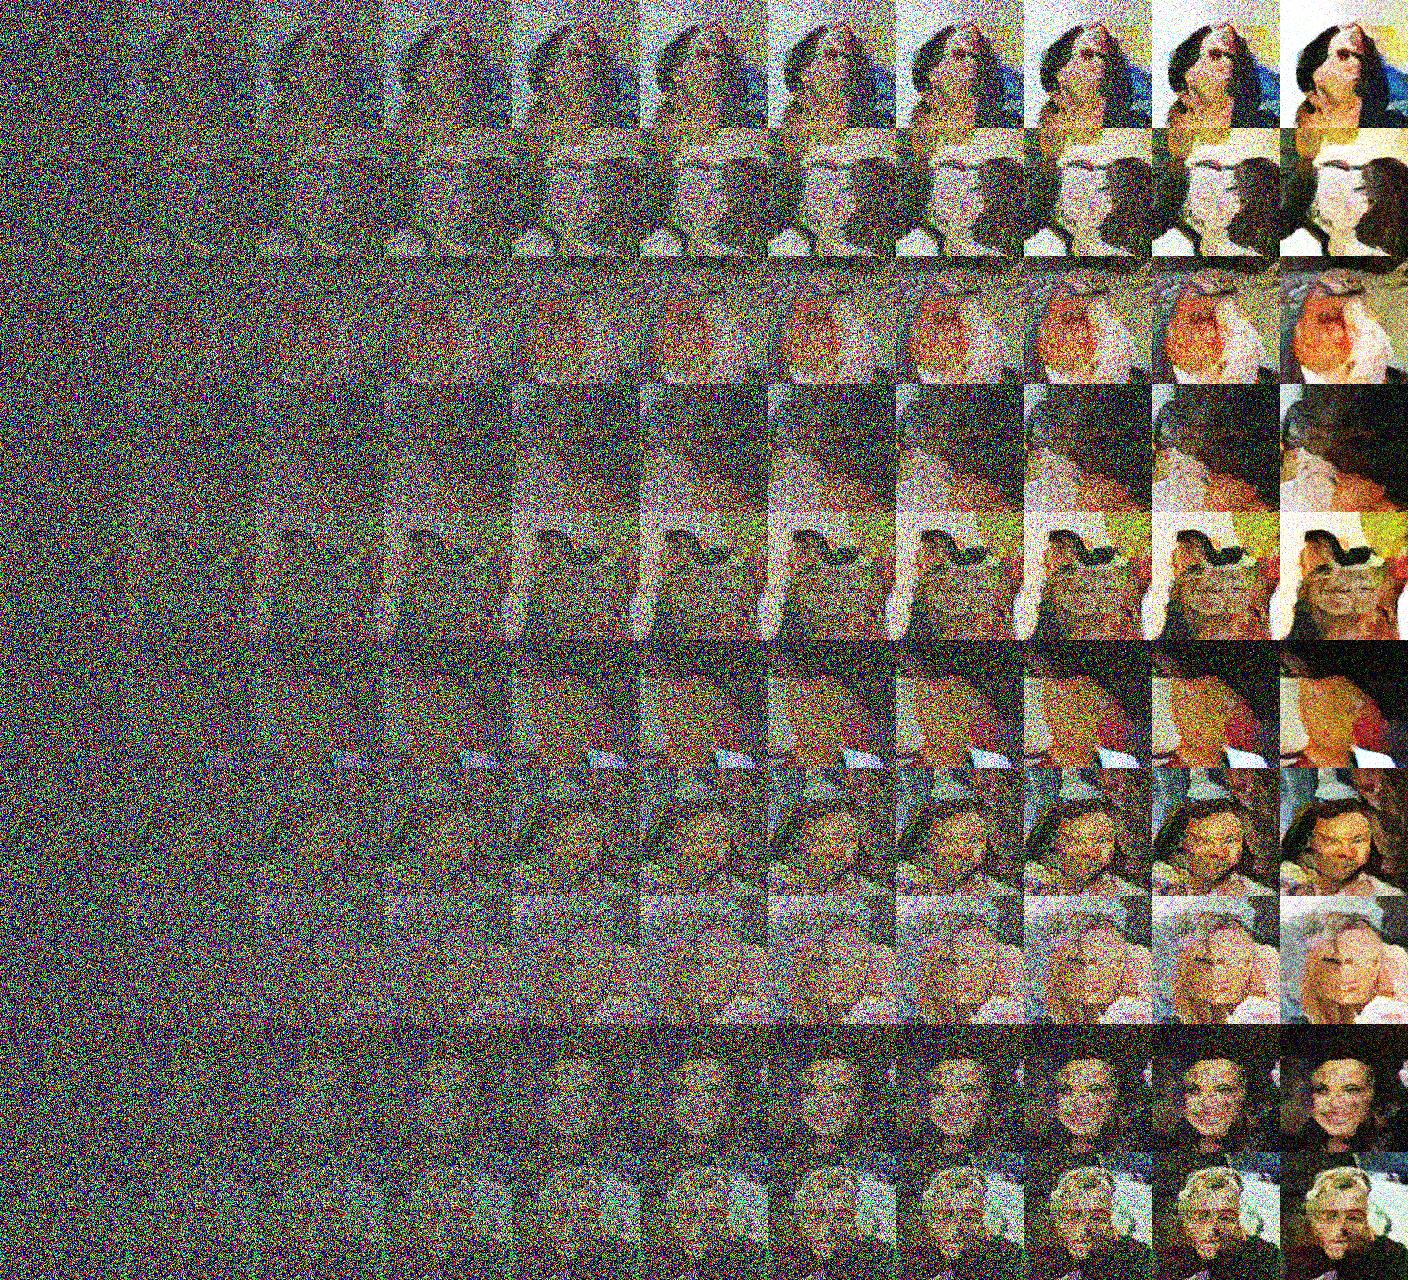

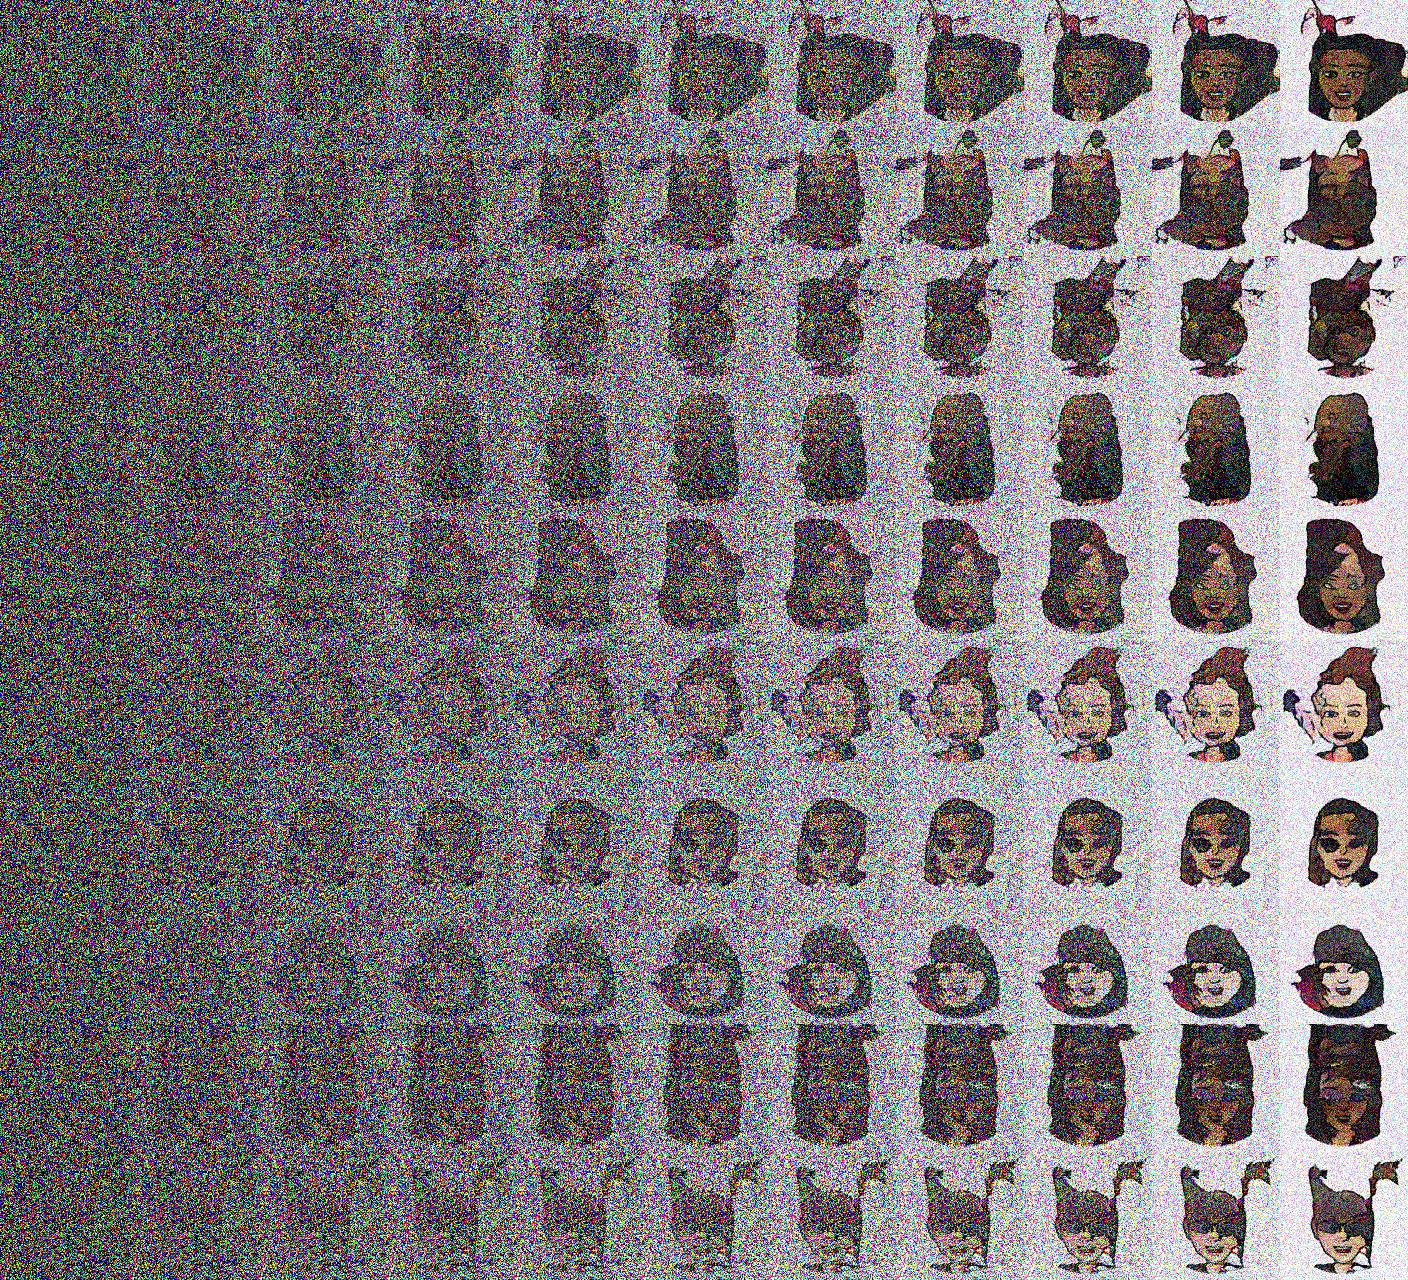

$\bf \text {2. FID Scores}$

In [23]:
!python -m pytorch_fid "E:/College/IISc_PhD/3rd_Semester/E9_333_Advance_Deep_Representation_Learning/Assignment/Assignment2/Code/Code_Q1/FID/bitemoji/Real" "E:/College/IISc_PhD/3rd_Semester/E9_333_Advance_Deep_Representation_Learning/Assignment/Assignment2/Code/Code_Q1/FID/bitemoji/Fake" --device cuda:0

!python -m pytorch_fid "E:/College/IISc_PhD/3rd_Semester/E9_333_Advance_Deep_Representation_Learning/Assignment/Assignment2/Code/Code_Q1/FID/celeba/Real" "E:/College/IISc_PhD/3rd_Semester/E9_333_Advance_Deep_Representation_Learning/Assignment/Assignment2/Code/Code_Q1/FID/celeba/Fake" --device cuda:0

!python -m pytorch_fid "E:/College/IISc_PhD/3rd_Semester/E9_333_Advance_Deep_Representation_Learning/Assignment/Assignment2/Code/Code_Q1/FID/celeba/Real" "E:/College/IISc_PhD/3rd_Semester/E9_333_Advance_Deep_Representation_Learning/Assignment/Assignment2/Code/Code_Q1/FID/celeba/Fake_GAN" --device cuda:0


FID:  129.61954595039856



100%|##########| 20/20 [00:04<00:00,  4.61it/s]

100%|##########| 20/20 [00:02<00:00,  7.30it/s]


FID:  288.64970831180403



100%|##########| 20/20 [00:04<00:00,  4.19it/s]

100%|##########| 20/20 [00:02<00:00,  6.81it/s]


FID:  356.958991151095



100%|##########| 20/20 [00:04<00:00,  4.15it/s]

100%|##########| 20/20 [00:03<00:00,  6.44it/s]


$\bf \text{3. Classifier Guided Diffusion Model results}$

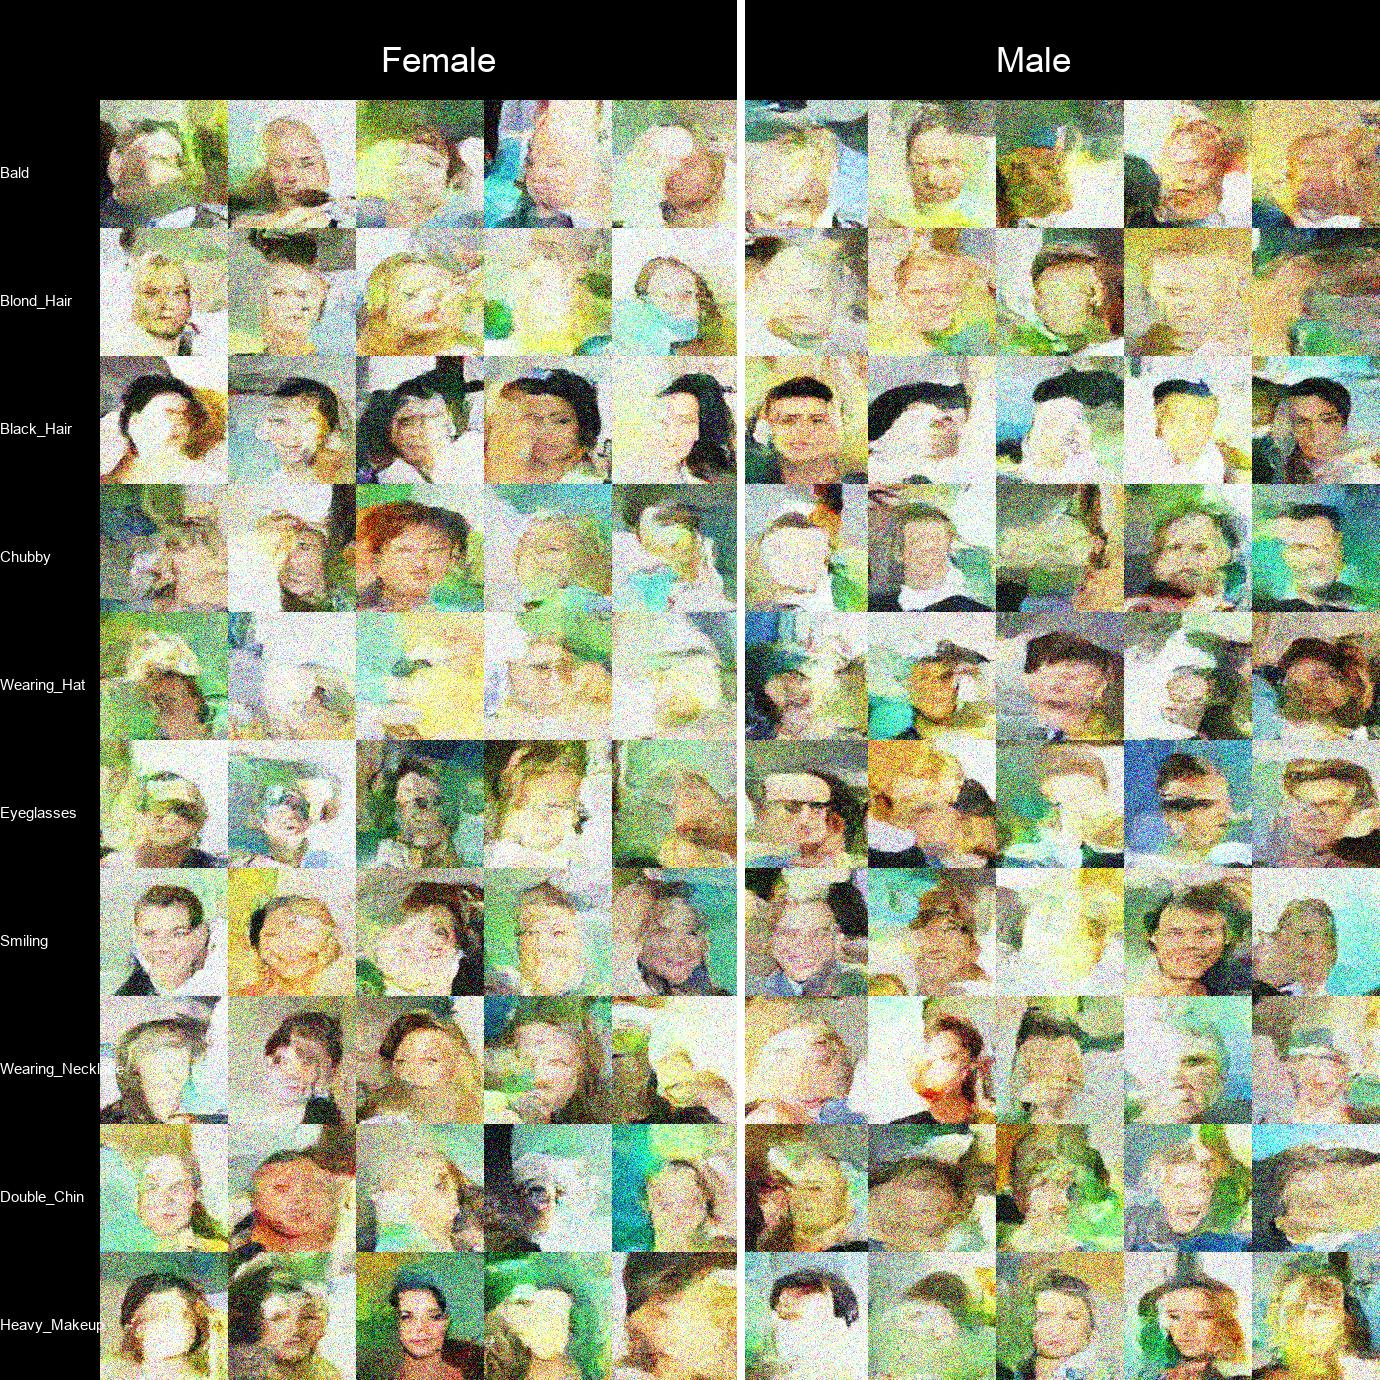